In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog
from skimage import color

def analyze_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    average_color = np.mean(img, axis=(0, 1))
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_percentage = np.sum(edges > 0) / (edges.shape[0] * edges.shape[1])
    
    gray_img = color.rgb2gray(img)
    fd, _ = hog(gray_img, orientations=8, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1), visualize=True)
    
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    shape_complexity = len(contours)
    
    return {
        'average_color': average_color,
        'edge_percentage': edge_percentage,
        'hog_features': fd,
        'shape_complexity': shape_complexity
    }

# Load the Pokemon data
df = pd.read_csv('csv/pokemon_train.csv')

# Initialize lists to store features
color_features = []
edge_features = []
hog_features = []
shape_features = []

# Process each image
for _, row in df.iterrows():
    image_path = os.path.join('/Users/marvinchen/Desktop/IW/cos-independent-work/pokemon_train_images', f"gen_{row['Generation']}", f"{row['Name']}.png")
    
    if os.path.exists(image_path):
        features = analyze_image(image_path)
        if features is not None:
            color_features.append(features['average_color'])
            edge_features.append(features['edge_percentage'])
            hog_features.append(features['hog_features'])
            shape_features.append(features['shape_complexity'])
        else:
            print(f"Failed to analyze image: {image_path}")
            color_features.append(np.zeros(3))
            edge_features.append(0)
            hog_features.append(np.zeros(64))  # Assuming 64 HOG features
            shape_features.append(0)
    else:
        print(f"Image not found: {image_path}")
        color_features.append(np.zeros(3))
        edge_features.append(0)
        hog_features.append(np.zeros(64))  # Assuming 64 HOG features
        shape_features.append(0)

# Convert lists to numpy arrays
color_features = np.array(color_features)
edge_features = np.array(edge_features)
hog_features = np.array(hog_features)
shape_features = np.array(shape_features)

# Create a new DataFrame with only name, types, generation, and image features
new_df = pd.DataFrame({
    'Name': df['Name'],
    'Primary_Type': df['Primary_Type'],
    'Secondary_Type': df['Secondary_Type'],
    'Generation': df['Generation'],
    'Color_R': color_features[:, 2],
    'Color_G': color_features[:, 1],
    'Color_B': color_features[:, 0],
    'Edge_Percentage': edge_features,
    'Shape_Complexity': shape_features
})

# Add HOG features
for i in range(hog_features.shape[1]):
    new_df[f'HOG_{i}'] = hog_features[:, i]

# Save the new DataFrame
new_df.to_csv('pokemon_with_image_features.csv', index=False)

print("Image analysis complete. Features added to new DataFrame and saved to CSV.")

/var/folders/wv/9_zfl0j17p31nyfms_71vgn40000gn/T/ipykernel_222/3188565313.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'HOG_{i}'] = hog_features[:, i]
/var/folders/wv/9_zfl0j17p31nyfms_71vgn40000gn/T/ipykernel_222/3188565313.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df[f'HOG_{i}'] = hog_features[:, i]
/var/folders/wv/9_zfl0j17p31nyfms_71vgn40000gn/T/ipykernel_222/3188565313.py:87: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

Image analysis complete. Features added to new DataFrame and saved to CSV.


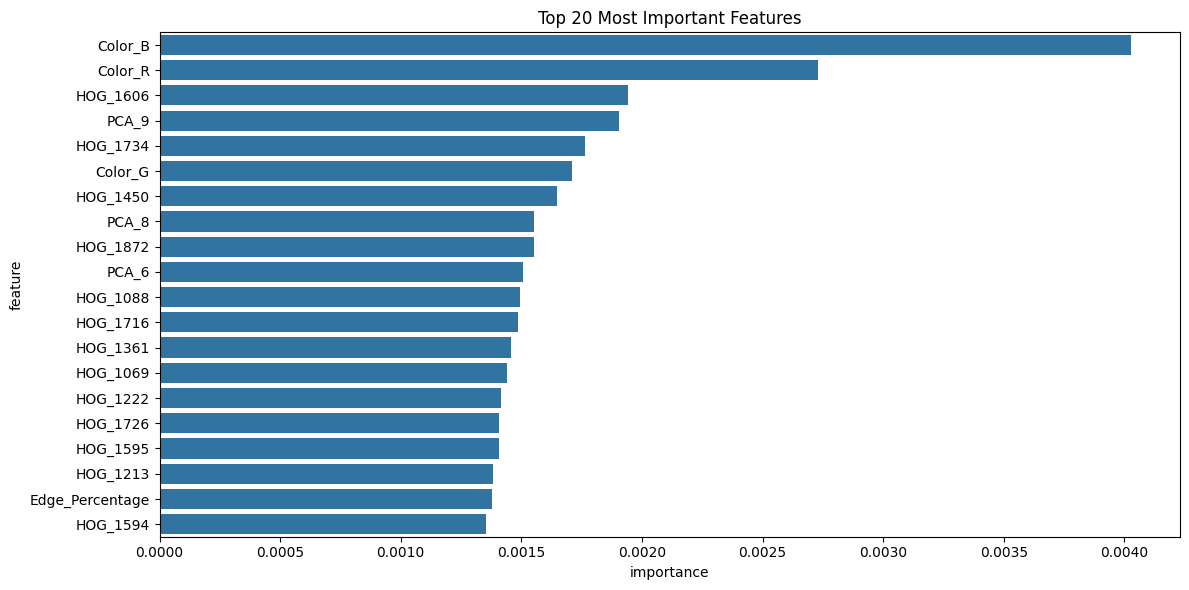

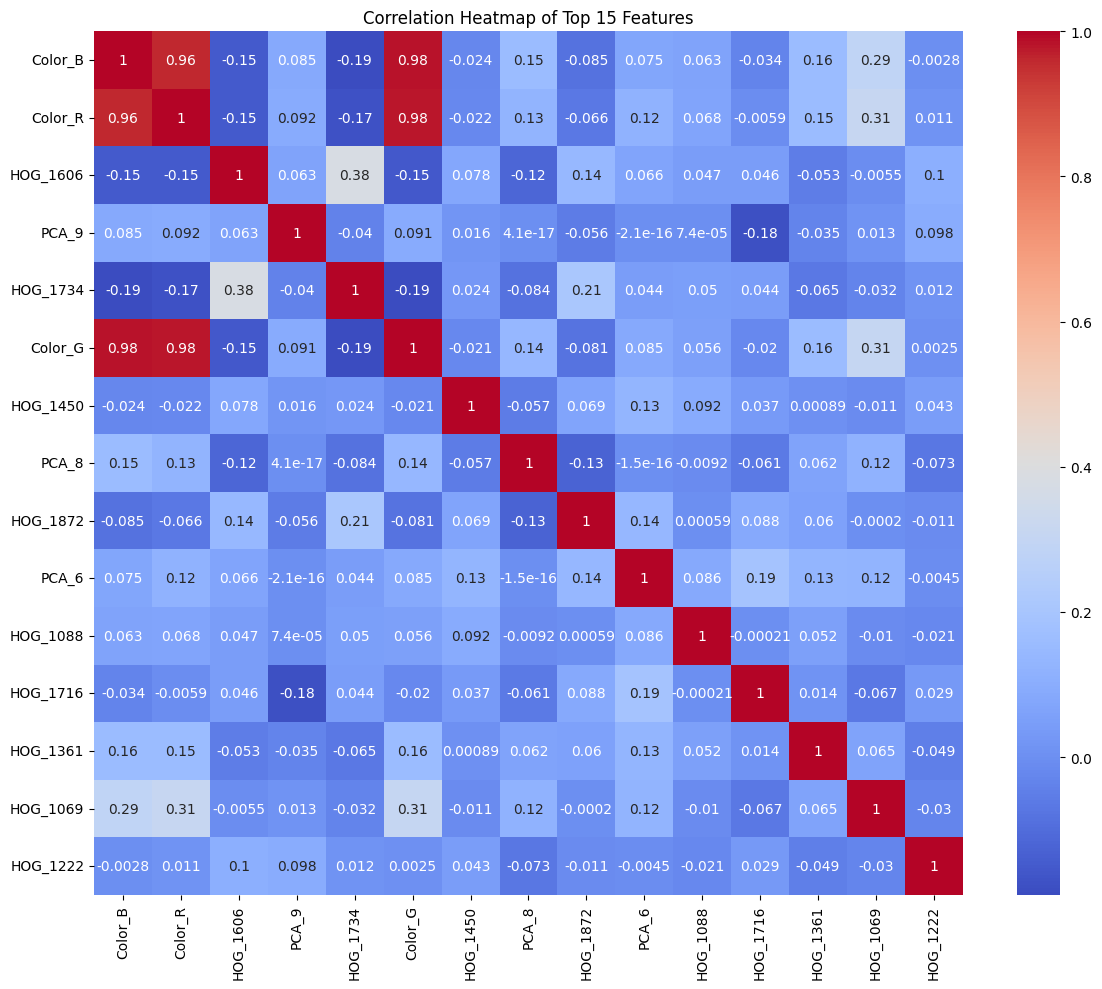

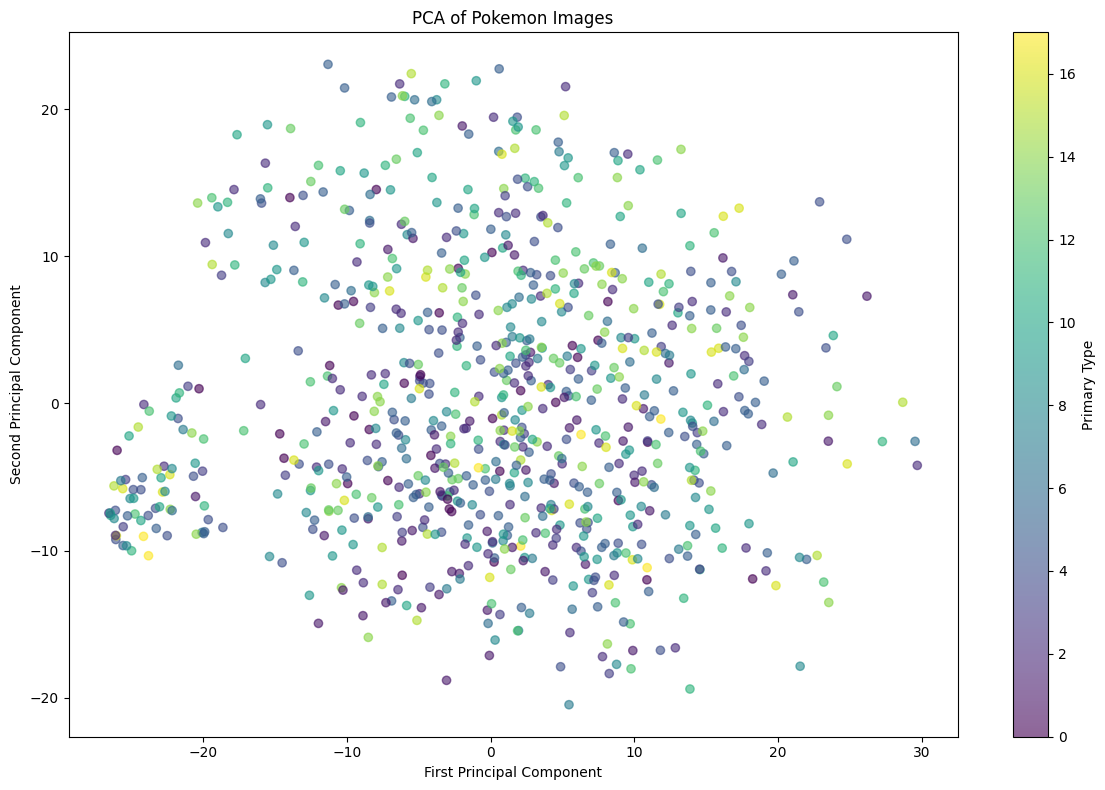

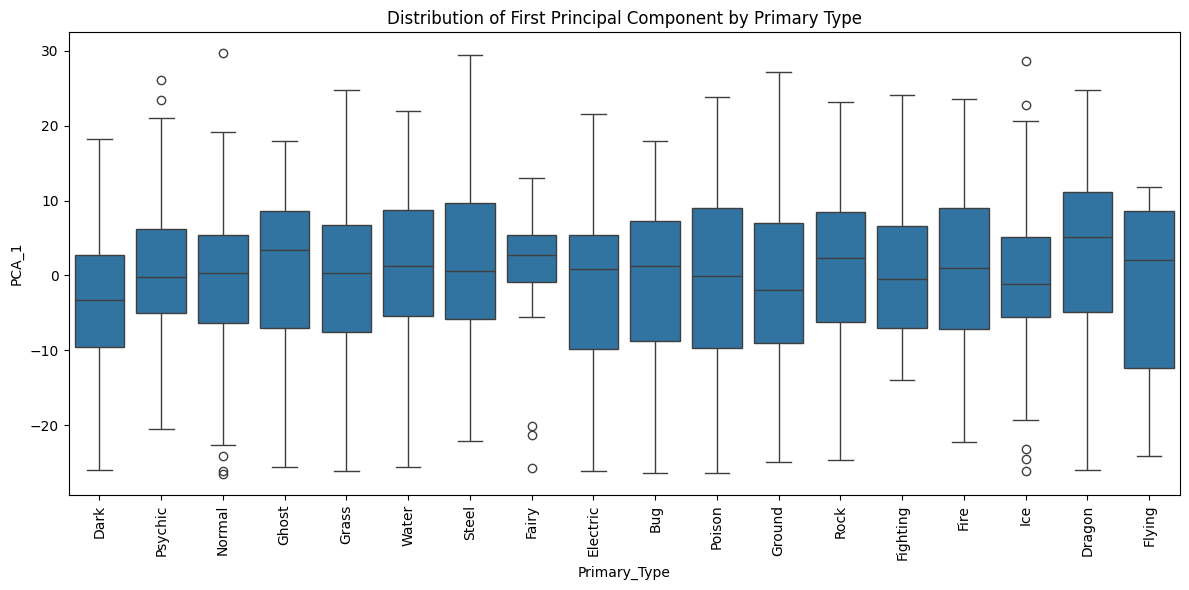

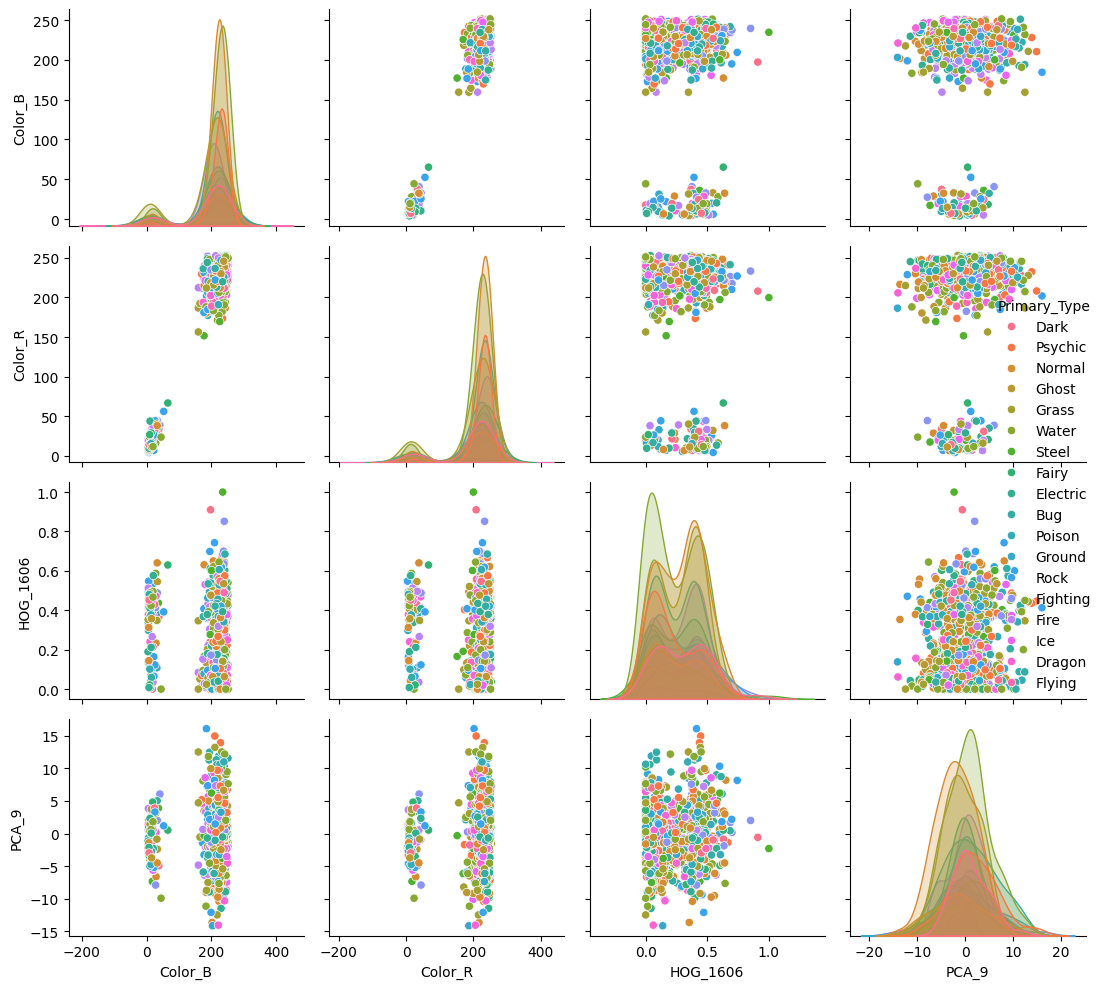

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Load the data
df = pd.read_csv('pokemon_with_image_features.csv')

# Separate HOG features
hog_features = df.filter(regex='^HOG_')

# PCA
scaler = StandardScaler()
hog_scaled = scaler.fit_transform(hog_features)
pca = PCA(n_components=10)
hog_pca = pca.fit_transform(hog_scaled)

# Add PCA components to dataframe
for i in range(10):
    df[f'PCA_{i+1}'] = hog_pca[:, i]

# Feature importance
X = df.drop(['Name', 'Primary_Type', 'Secondary_Type', 'Generation'], axis=1)
y = df['Primary_Type']
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Visualizations
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

# Correlation heatmap of top features
top_features = feature_importance['feature'].head(15).tolist()
plt.figure(figsize=(12, 10))
sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Top 15 Features')
plt.tight_layout()
plt.show()

# Scatter plot of top 2 PCA components colored by Primary Type
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['PCA_1'], df['PCA_2'], c=pd.factorize(df['Primary_Type'])[0], alpha=0.6)
plt.title('PCA of Pokemon Images')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter, label='Primary Type')
plt.tight_layout()
plt.show()

# Box plot of top PCA component by Primary Type
plt.figure(figsize=(12, 6))
sns.boxplot(x='Primary_Type', y='PCA_1', data=df)
plt.title('Distribution of First Principal Component by Primary Type')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Pair plot of top 4 features
top_4_features = feature_importance['feature'].head(4).tolist()
sns.pairplot(df, vars=top_4_features, hue='Primary_Type')
plt.tight_layout()
plt.show()

In [3]:
from sklearn.decomposition import PCA

# Assuming 'hog_features' is your DataFrame with all HOG features
pca = PCA(n_components=10)  # Adjust the number of components as needed
hog_pca = pca.fit_transform(hog_features)

# Create a new DataFrame with PCA components
hog_pca_df = pd.DataFrame(hog_pca, columns=[f'HOG_PCA_{i}' for i in range(hog_pca.shape[1])])

# Combine with other features
df_final = pd.concat([df[['Name', 'Primary_Type', 'Secondary_Type', 'Generation']], hog_pca_df], axis=1)

In [4]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select top k HOG features
k = 10  # Adjust as needed
selector = SelectKBest(f_classif, k=k)
hog_selected = selector.fit_transform(hog_features, df['Primary_Type'])

# Get selected feature names
selected_features = hog_features.columns[selector.get_support()].tolist()

# Create new DataFrame with selected features
df_final = pd.concat([df[['Name', 'Primary_Type', 'Secondary_Type', 'Generation']], 
                      hog_features[selected_features]], axis=1)

df_final.to_csv('pokemon_with_pca_features.csv', index=False)


/Users/marvinchen/Desktop/IW/cos-independent-work/cos397/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1 7] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/marvinchen/Desktop/IW/cos-independent-work/cos397/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Number of components explaining 95% of variance: 3


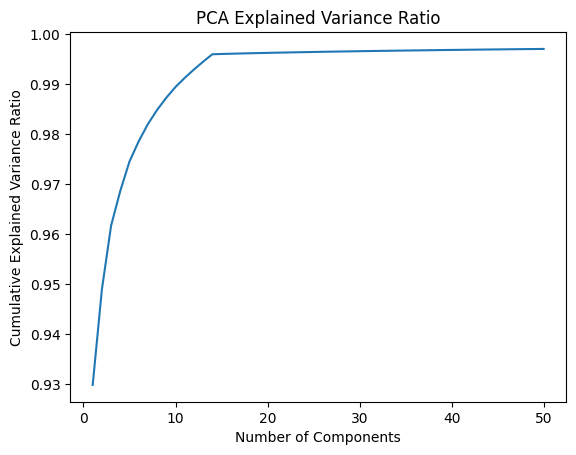

In [8]:
from sklearn.decomposition import PCA
import numpy as np

# Assuming 'X' is your feature matrix
pca = PCA(n_components=50)
pca.fit(X)

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Find number of components that explain 95% of variance
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1

print(f"Number of components explaining 95% of variance: {n_components_95}")

# Plot the cumulative explained variance ratio
import matplotlib.pyplot as plt

plt.plot(range(1, 51), cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.show()

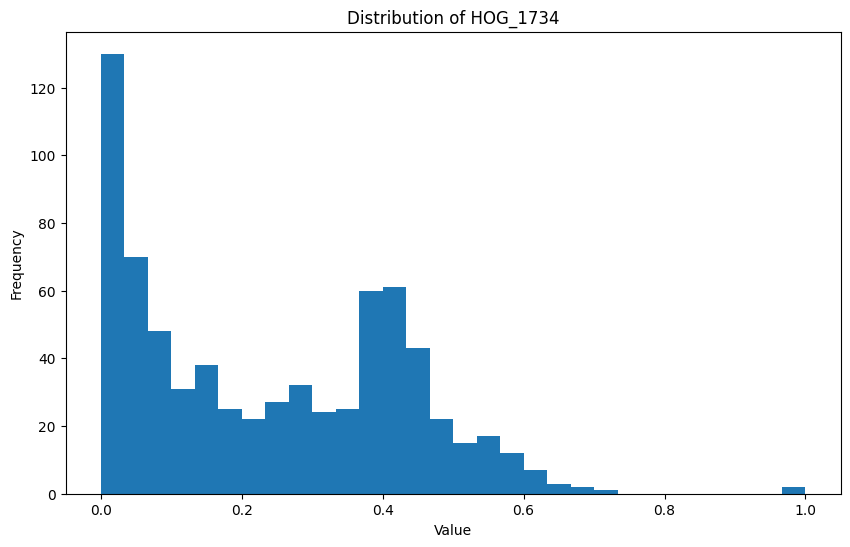

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(df['HOG_1734'], bins=30)
plt.title('Distribution of HOG_1734')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

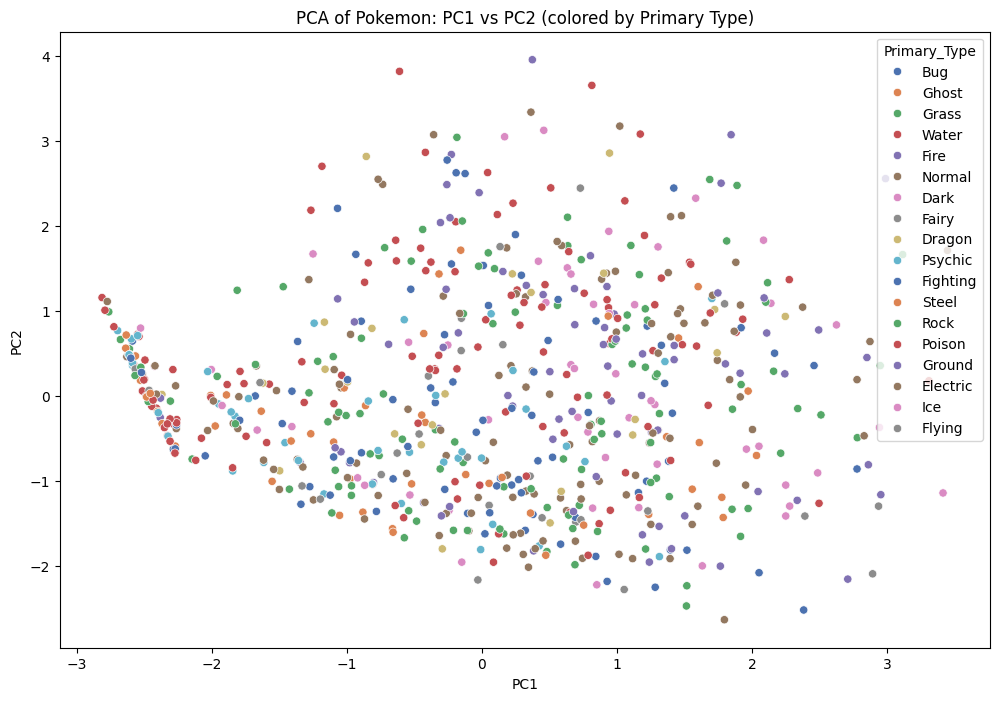

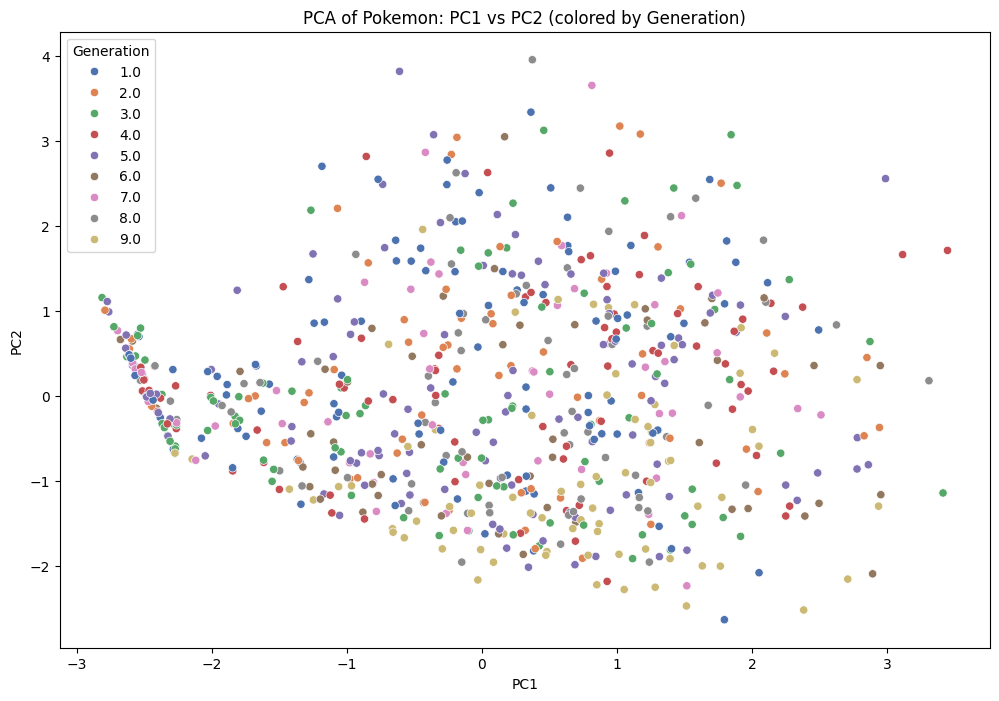

/var/folders/wv/9_zfl0j17p31nyfms_71vgn40000gn/T/ipykernel_1280/1064016439.py:50: UserWarning: Mismatched number of handles and labels: len(handles) = 9 len(labels) = 18
  plt.legend(handles=scatter.legend_elements()[0], labels=pca_df['Primary_Type'].unique(),


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

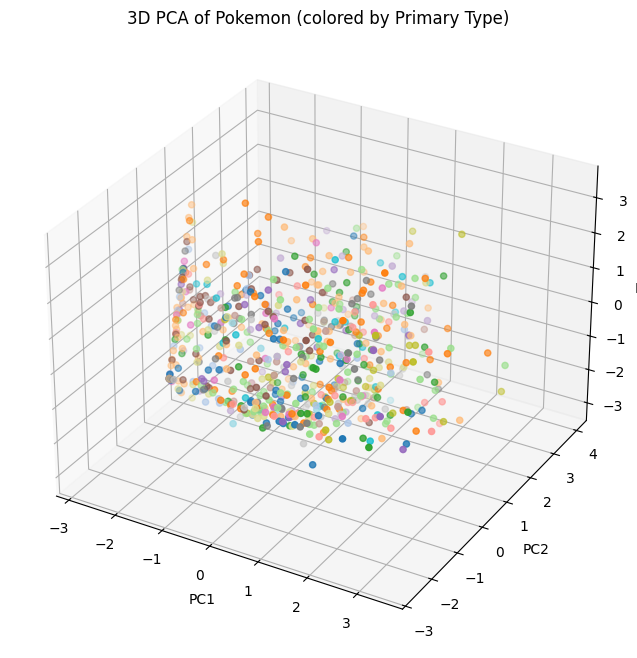

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_csv('pokemon_with_pca_features.csv')

# Separate the HOG features
hog_features = df.filter(regex='^HOG_')

# Standardize the features
scaler = StandardScaler()
hog_scaled = scaler.fit_transform(hog_features)

# Perform PCA
pca = PCA(n_components=3)  # We'll keep the first 3 components
hog_pca = pca.fit_transform(hog_scaled)

# Create a new DataFrame with PCA components
pca_df = pd.DataFrame(data=hog_pca, columns=['PC1', 'PC2', 'PC3'])

# Add the Pokemon type and generation to this dataframe
pca_df['Primary_Type'] = df['Primary_Type']
pca_df['Generation'] = df['Generation']

# Create a scatter plot of the first two principal components, colored by Primary Type
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Primary_Type', palette='deep')
plt.title('PCA of Pokemon: PC1 vs PC2 (colored by Primary Type)')
plt.show()

# Create a scatter plot of the first two principal components, colored by Generation
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Generation', palette='deep')
plt.title('PCA of Pokemon: PC1 vs PC2 (colored by Generation)')
plt.show()

# 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], 
                     c=pd.factorize(pca_df['Primary_Type'])[0], cmap='tab20')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('3D PCA of Pokemon (colored by Primary Type)')
plt.legend(handles=scatter.legend_elements()[0], labels=pca_df['Primary_Type'].unique(), 
           title="Primary Type", loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Print the explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)